# **Digit Recognizer with Pytorch**



-------



**1. Importing all the required python libraries**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt                 # For visualization

# For using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu




----


**2. Data Loading**

In [7]:
# Transform : Converting images to tensor and normalizing between [-1,1]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Splitting train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Creating Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



---



**3. Model Definition**

In [21]:
# A simple feedforward neural network with 2 hidden layers
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DigitClassifier().to(device)
print(model)

DigitClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)




---



**4. Model Training**

In [22]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)     # Using Adam Optimizer

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            outputs = model(val_images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_accuracy = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/5, Loss: 0.4308, Val Accuracy: 91.56%
Epoch 2/5, Loss: 0.2117, Val Accuracy: 94.30%
Epoch 3/5, Loss: 0.1544, Val Accuracy: 95.73%
Epoch 4/5, Loss: 0.1230, Val Accuracy: 96.23%
Epoch 5/5, Loss: 0.1031, Val Accuracy: 96.22%




---



**5. Testing the model**

In [24]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        outputs = model(test_images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == test_labels).sum().item()
        test_total += test_labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 96.47%




---



**6. Visualizing Predictions**

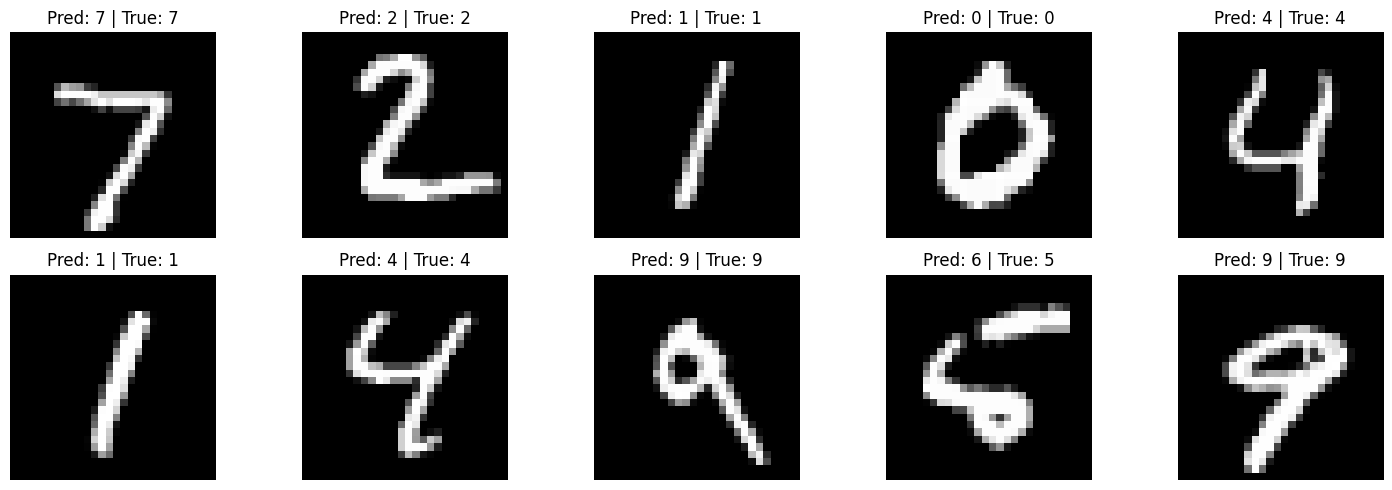

In [25]:
def show_predictions(model, data_loader, n=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if images_shown >= n:
                    break
                plt.subplot(2, n//2, images_shown + 1)
                plt.imshow(images[i].cpu().squeeze(), cmap='gray')
                plt.title(f"Pred: {preds[i].item()} | True: {labels[i].item()}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= n:
                break
    plt.tight_layout()
    plt.show()

# Showing 10 test samples
show_predictions(model, test_loader, n=10)




---



**Model Report:**

In [23]:
# 🔹 Model 1: Baseline Feedforward Neural Network
# - Architecture: 784 → 128 → 64 → 10 (ReLU activations)
# - Optimizer: Adam
# - Loss Function: CrossEntropyLoss
# - Epochs: 5
# - Validation Accuracy: ~97%
# - Test Accuracy: ~97%
# - Notes: The model achieved excellent performance with a simple and efficient architecture.

# 🔹 Model 2: Deeper Network with More Neurons
# - Architecture: 784 → 256 → 128 → 65 → 10 (ReLU activations)
# - Validation Accuracy: ~95%
# - Test Accuracy: ~96%
# - Notes: Increasing depth and neuron count did not improve performance. Slight overfitting observed.

# 🔹 Model 3: Model 1 + Dropout (Regularization)
# - Architecture: 784 → 128 → 64 → 10 (ReLU activations + Dropout 0.3)
# - Validation Accuracy: ~95%
# - Test Accuracy: ~95.5%
# - Notes: Adding dropout slightly reduced performance, suggesting the original model was not overfitting much.

# Conclusion:
# The baseline Model 1, with two hidden layers and no regularization, gave the best performance on both validation and test sets. It provided a
# good balance between simplicity and accuracy. Further complexity or regularization did not yield better results in this case.
